In [1]:
import sys
import os
from pathlib import Path

# 1. Setup path to import configs
current_dir = Path(os.getcwd())
# Assuming current path is scripts/S4/S4.1/, move up 3 levels to root
project_root = current_dir.parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# 2. Import parameters
from configs.best_models import MODEL_PARAMS

# 3. Import utility modules
import utils_BiLSTMasTrue
import utils_BiLasTrue_ReLU
import pandas as pd
import matplotlib.pyplot as plt
import utils

print("Successfully imported MODEL_PARAMS.")

# 4. Helper function to select model module and directionality
def get_model_settings(arch_name):
    """
    Returns the corresponding module and bidirectional flag based on architecture name.
    """
    if "ReLU" in arch_name:
        # For LSTMReLU
        return utils_BiLasTrue_ReLU, False 
    elif "BiLSTM" in arch_name:
        # For BiLSTM
        return utils_BiLSTMasTrue, True     # Enable bidirectional
    else:
        # Default to standard LSTM
        return utils_BiLSTMasTrue, False    # Disable bidirectional

Successfully imported MODEL_PARAMS.


In [2]:
INPUT_DIR = utils.RESULTS_DIR / "S1" / "S1.1"

# --- Output Directory ---
# Target Location: results/S4/S4.1
OUTPUT_DIR = utils.RESULTS_DIR / "S4" / "S4.1"

# Automatically create the output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Reading inputs from: {INPUT_DIR}")
print(f"Saving outputs to: {OUTPUT_DIR}")

# ==========================================
# 2. Load Data (From Upstream)
# ==========================================

# Define the input file path (Whole Decedents Dataset)
# Note: The screenshot shows the file is in 'inputs/' inside the S4.1 folder, 
# but for reproducibility, we should read from the S1 result location.
train_file_path = INPUT_DIR / "NIAvalueUpdatedVersion_scaled_whole_decedents_dataset.pkl"

# Validation check
if not train_file_path.exists():
    raise FileNotFoundError(f"Input file not found: {train_file_path}\nPlease run S1.1 first.")

# Load the pickle file
total_data = pd.read_pickle(train_file_path)
print(f"Successfully loaded data: {train_file_path.name}")
print(f"Dataset shape: {total_data.shape}")

Reading inputs from: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/results/S1/S1.1
Saving outputs to: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/results/S4/S4.1
Successfully loaded data: NIAvalueUpdatedVersion_scaled_whole_decedents_dataset.pkl
Dataset shape: (114, 65)


In [3]:
# Define save path using OUTPUT_DIR
gpath_model_save_path = OUTPUT_DIR / "final_model_gpath_LSTMReLU.pth"
tangles_model_save_path = OUTPUT_DIR / "final_model_tangles_LSTM.pth"
amyloid_model_save_path = OUTPUT_DIR / "final_model_amyloid_BiLSTM.pth"
nia_model_save_path = OUTPUT_DIR / "final_model_nia_BiLSTM.pth"

In [4]:
total_data # Previous one has the following dataset. 11905 rows x 65 columns.

,projid,fu_year,study,cogdx,age_at_visit,bmi,cogn_global,cts_mmse30,dbp_avg,sbp_avg,...,rigidsc,tremsc,q1slp,q2slp,q4slp,q5slp,gpath,tangles,amyloid,niareagansc
0,100005,9,C,2,0.425297,1.000000,0.353278,0.651022,0.376058,0.782514,...,0.159673,0.682549,0.444444,0.555556,1.000000,0.444444,0.626760,1.000000,0.043756,0.222222
1,100007,5,C,3,0.017459,0.501073,0.611834,0.728192,0.966888,0.574287,...,0.430482,0.400779,0.666667,1.000000,0.111111,0.444444,0.887436,0.472581,0.295863,0.222222
2,100010,4,A,3,0.908041,0.074814,0.060722,0.060125,0.012077,0.412323,...,0.946570,0.497923,0.333333,0.888889,0.666667,0.111111,0.295195,0.550705,0.142809,0.888889
3,100012,8,ROS,5,0.688482,0.511159,0.960412,0.870351,0.225086,0.004103,...,0.188080,0.977676,0.222222,1.000000,0.222222,0.000000,0.613415,0.508365,0.947648,1.000000
4,100026,0,C,6,0.603280,0.297568,0.596617,0.984795,0.443655,0.752799,...,0.175163,0.836020,0.555556,0.888889,0.222222,0.222222,0.354513,0.621145,1.000000,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,100579,4,C,1,0.756557,0.095992,0.684264,0.633621,0.726835,0.606618,...,0.136845,0.064320,0.000000,0.444444,0.222222,1.000000,0.874033,0.398477,0.253349,0.888889
110,100586,9,ROS,1,0.397347,0.009373,0.120357,0.578149,0.000000,0.481740,...,0.823860,0.231639,0.444444,0.444444,0.222222,0.222222,0.054552,0.465776,0.549699,0.666667
111,100588,4,ROS,3,0.150624,0.438376,0.887288,0.284459,0.519528,0.946881,...,0.275394,0.000000,0.777778,0.666667,0.333333,0.888889,0.668945,0.628916,0.066784,0.111111
112,100593,3,MAP,7,0.142854,0.530734,0.988458,1.000000,0.512422,0.881027,...,0.198367,0.516281,0.555556,0.333333,0.000000,0.333333,0.404322,0.451073,0.906744,0.777778


# Final model for gpath (LSTMReLU).

In [5]:
# ==========================================
# GPATH Training
# ==========================================
target_name = 'gpath'
cfg = MODEL_PARAMS[target_name]
hp = cfg['hyperparameters']

print(f"--- Training {target_name} ---")
print(f"Architecture: {cfg['architecture']}")
print(f"Hyperparameters: {hp}")

# 1. Dynamically select module
current_module, is_bidirectional = get_model_settings(cfg['architecture'])

# 2. Prepare Data
# Note: Using target_columns from config to ensure consistency
feature_columns = total_data.drop(columns=['projid', 'study', 'fu_year', 'cogdx', 
                                             'amyloid', 'gpath', 'tangles', 'niareagansc']).columns.tolist()
target_columns = cfg['target_columns']

train_ids = total_data.projid.unique()
train_sequences = current_module.create_sequences(total_data, train_ids, feature_columns, target_columns)

test_ids = total_data.projid.unique()
test_sequences = current_module.create_sequences(total_data, test_ids, feature_columns, target_columns)

test_r2, train_loss, val_loss, lr_history = utils_BiLasTrue_ReLU.train_and_evaluate_model(
    train_data=train_sequences,
    test_data=test_sequences,
    input_dim=len(feature_columns),
    output_dim=len(target_columns),  
    num_epochs=500,
    patience=10,
    lr_scheduler_patience=5,
    lr_factor=0.5,
    hidden_size=8,
    num_layers=4,
    batch_size=16,
    learning_rate=0.01,
    seed=1217,
    temporary=True,
    dropout_rate=0,
    bidirectional=is_bidirectional
)

--- Training gpath ---
Architecture: LSTMReLU
Hyperparameters: {'hidden_size': 8, 'num_layers': 4, 'learning_rate': 0.01, 'dropout_rate': 0.0, 'batch_size': 16}


/Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/scripts/S4_Training_ML_Models_and_Predicting_Pathologies_only_for_Livings/S4.1_Retraining_using_all_decedents_samples_for_imputing_pathologies_for_livings/utils_BiLasTrue_ReLU.py:478: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where y

In [6]:
test_r2_with_names = dict(zip(target_columns, [round(value, 6) for value in test_r2]))
print(test_r2_with_names)

{'gpath': 0.089672, 'tangles': 0.352129, 'niareagansc': 0.290502}


- Using the best parameter for gpath, the LSTM test $R^2$ for gpath is 0.309175
- The elastic-net test $R^2$ for gpath is 0.262

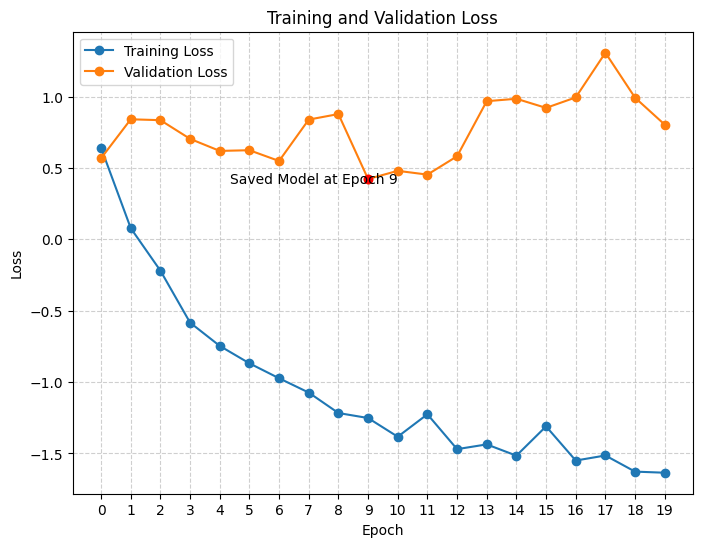

In [7]:
import numpy as np
epochs = np.arange(len(train_loss))
lowest_val_idx = np.argmin(val_loss)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Annotate the lowest validation loss
plt.scatter(lowest_val_idx, val_loss[lowest_val_idx], color='red', zorder=3)
plt.text(lowest_val_idx + 1, val_loss[lowest_val_idx] - 0.05, 
         f'Saved Model at Epoch {lowest_val_idx}', 
         fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(epochs)  # Set x-axis ticks explicitly as factors (0, 1, 2, ...)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The model demonstrates strong learning ability during the early training phase (Epoch 0-8: both training and validation loss decrease steadily), indicating that parameters are being effectively optimized. After Epoch 9, validation loss shows a clear reversal and continues to increase while training loss keeps decreasing, resulting in a pronounced divergence, which is a classic signal of overfitting and suggests a decline in generalization performance. The current model has likely passed the optimal training point and should stop training early or apply stronger regularization to avoid further overfitting.

Conclusion: The model exhibits an overfitting pattern. It is recommended to apply early stopping or enhance regularization techniques (e.g., dropout or L2 penalty) to preserve the best model state and improve generalizability.

When you collect the "training loss" during each epoch, you're effectively averaging the loss across all mini‐batches, including the very first batches of that epoch when the model parameters are still relatively unoptimized (or only partially updated). By the time you finish the epoch, the model has been updated multiple times, so when you switch to evaluation mode (model.eval()) and compute the "validation loss," that loss is based on the final state of the model at the end of the epoch—i.e., a model that's already received a full epoch's worth of updates.

Hence, it's not unusual to see:

- Training Loss (Epoch Average): Higher (especially early batches) because it includes loss from the very start of the epoch.
- Validation Loss (After Epoch): Potentially lower because it uses the (better) model at the end of the epoch's training.

### Train the selected model on the entire dataset (all decedents) to predict estimated brain pathologies for subsequent clustering analysis.

In [8]:
all_ids = total_data.projid.unique()
all_sequences = current_module.create_sequences(total_data, all_ids, feature_columns, target_columns)

training_r2, train_loss, val_loss, lr_history = utils_BiLasTrue_ReLU.train_and_evaluate_model(
    train_data=all_sequences,
    test_data=all_sequences,
    input_dim=len(feature_columns),
    output_dim=len(target_columns),  
    num_epochs=500,
    patience=10,
    lr_scheduler_patience=5,
    lr_factor=0.5,
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    batch_size=hp['batch_size'],
    learning_rate=hp['learning_rate'],
    dropout_rate=hp['dropout_rate'],
    bidirectional=is_bidirectional, 
    seed=1217,
    model_save_path=str(gpath_model_save_path) 
)

/Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/scripts/S4_Training_ML_Models_and_Predicting_Pathologies_only_for_Livings/S4.1_Retraining_using_all_decedents_samples_for_imputing_pathologies_for_livings/utils_BiLasTrue_ReLU.py:478: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where y

The current train_data and test_data are both all_sequences because the model is being trained on the full pool of sequences constructed from all decedents. In this run, the “test_data” does not refer to a held-out external test set for final reporting — it serves as the validation split drawn from the same decedent sequence pool during training, used to track validation loss and select the best model checkpoint via early stopping (e.g., the saved epoch-4 model).

This design is intentional because the model is in its fitting and model-selection stage, where it must learn from maximum available pathology trajectories (decedents) to optimize parameters and determine the optimal stopping point. Once trained, the best checkpointed model will be transferred and deployed to generate predictions for living participants, who are the true target population for inference.

In [9]:
training_r2_with_names = dict(zip(target_columns, [round(value, 4) for value in training_r2]))
print(training_r2_with_names)

{'gpath': 0.0897, 'tangles': 0.3521, 'niareagansc': 0.2905}


Training $R^2$s look reasonable. 

# Final model for tangles (LSTM)

In [10]:
# ==========================================
# TANGLES Training
# ==========================================
target_name = 'tangles'
cfg = MODEL_PARAMS[target_name]
hp = cfg['hyperparameters']

print(f"--- Training {target_name} ---")
print(f"Hyperparameters: {hp}")

# 1. Dynamically select module
current_module, is_bidirectional = get_model_settings(cfg['architecture'])

# 2. Prepare Data
feature_columns = total_data.drop(columns=['projid', 'study', 'fu_year', 'cogdx', 
                                             'amyloid', 'gpath', 'tangles', 'niareagansc']).columns.tolist()
target_columns = cfg['target_columns']

train_ids = total_data.projid.unique()
train_sequences = current_module.create_sequences(total_data, train_ids, feature_columns, target_columns)

test_ids = total_data.projid.unique()
test_sequences = current_module.create_sequences(total_data, test_ids, feature_columns, target_columns)

# 3. Train Model
test_r2, train_loss, val_loss, lr_history = current_module.train_and_evaluate_model(
    train_data=train_sequences,
    test_data=test_sequences,
    input_dim=len(feature_columns),
    output_dim=len(target_columns),  
    num_epochs=500,
    patience=10,
    lr_scheduler_patience=5,
    lr_factor=0.5,
    # --- Load from Config ---
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    batch_size=hp['batch_size'],
    learning_rate=hp['learning_rate'],
    dropout_rate=hp['dropout_rate'],
    bidirectional=is_bidirectional, 
    # --------------------
    seed=1217,
    temporary=True
)

--- Training tangles ---
Hyperparameters: {'hidden_size': 16, 'num_layers': 3, 'learning_rate': 0.01, 'dropout_rate': 0.0, 'batch_size': 64}


/Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/scripts/S4_Training_ML_Models_and_Predicting_Pathologies_only_for_Livings/S4.1_Retraining_using_all_decedents_samples_for_imputing_pathologies_for_livings/utils_BiLSTMasTrue.py:476: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

In [11]:
test_r2_with_names = dict(zip(target_columns, [round(value, 6) for value in test_r2]))
print(test_r2_with_names)

{'amyloid': 0.33621, 'niareagansc': 0.30052, 'tangles': 0.341696}


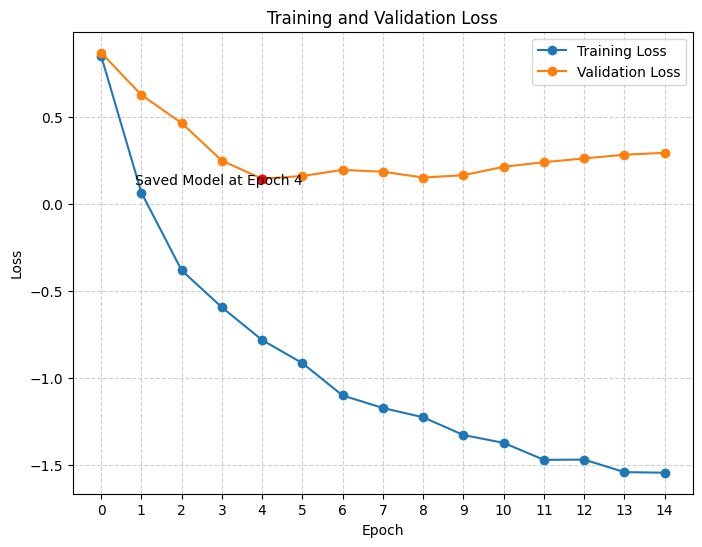

In [12]:
import numpy as np
epochs = np.arange(len(train_loss))
lowest_val_idx = np.argmin(val_loss)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Annotate the lowest validation loss
plt.scatter(lowest_val_idx, val_loss[lowest_val_idx], color='red', zorder=3)
plt.text(lowest_val_idx + 1, val_loss[lowest_val_idx] - 0.05, 
         f'Saved Model at Epoch {lowest_val_idx}', 
         fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(epochs)  # Set x-axis ticks explicitly as factors (0, 1, 2, ...)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [13]:
all_ids = total_data.projid.unique()
all_sequences = utils_BiLSTMasTrue.create_sequences(total_data, all_ids, feature_columns, target_columns)

training_r2, train_loss, val_loss, lr_history = utils_BiLSTMasTrue.train_and_evaluate_model(
    train_data=all_sequences,
    test_data=all_sequences,
    input_dim=len(feature_columns),
    output_dim=len(target_columns),  
    num_epochs=500,
    patience=10,
    lr_scheduler_patience=5,
    lr_factor=0.5,
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    batch_size=hp['batch_size'],
    learning_rate=hp['learning_rate'],
    dropout_rate=hp['dropout_rate'],
    bidirectional=is_bidirectional, 
    seed=1217,
    model_save_path=str(tangles_model_save_path)
)

/Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/scripts/S4_Training_ML_Models_and_Predicting_Pathologies_only_for_Livings/S4.1_Retraining_using_all_decedents_samples_for_imputing_pathologies_for_livings/utils_BiLSTMasTrue.py:476: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

In [14]:
training_r2_with_names = dict(zip(target_columns, [round(value, 6) for value in training_r2]))
print(training_r2_with_names)

{'amyloid': 0.33621, 'niareagansc': 0.30052, 'tangles': 0.341696}


# Final model for amyloid (BiLSTM)

In [15]:
# ==========================================
# AMYLOID Training
# ==========================================
target_name = 'amyloid'
cfg = MODEL_PARAMS[target_name]
hp = cfg['hyperparameters']

print(f"--- Training {target_name} ---")
print(f"Architecture: {cfg['architecture']}") # Should be BiLSTM

# 1. Dynamically select module
current_module, is_bidirectional = get_model_settings(cfg['architecture'])

# 2. Prepare Data
feature_columns = total_data.drop(columns=['projid', 'study', 'fu_year', 'cogdx', 
                                             'amyloid', 'gpath', 'tangles', 'niareagansc']).columns.tolist()
target_columns = cfg['target_columns']

train_ids = total_data.projid.unique()
train_sequences = current_module.create_sequences(total_data, train_ids, feature_columns, target_columns)

test_ids = total_data.projid.unique()
test_sequences = current_module.create_sequences(total_data, test_ids, feature_columns, target_columns)

# 3. Train Model
test_r2, train_loss, val_loss, lr_history = current_module.train_and_evaluate_model(
    train_data=train_sequences,
    test_data=test_sequences,
    input_dim=len(feature_columns),
    output_dim=len(target_columns),  
    num_epochs=500,
    patience=10,
    lr_scheduler_patience=5,
    lr_factor=0.5,
    # --- Load from Config ---
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    batch_size=hp['batch_size'],
    learning_rate=hp['learning_rate'],
    dropout_rate=hp['dropout_rate'],
    bidirectional=is_bidirectional, # This will be True
    # --------------------
    seed=1217,
    temporary=True
)

--- Training amyloid ---
Architecture: BiLSTM


/Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/scripts/S4_Training_ML_Models_and_Predicting_Pathologies_only_for_Livings/S4.1_Retraining_using_all_decedents_samples_for_imputing_pathologies_for_livings/utils_BiLSTMasTrue.py:476: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

In [16]:
test_r2_with_names = dict(zip(target_columns, [round(value, 6) for value in test_r2]))
print(test_r2_with_names)

{'gpath': 0.313897, 'tangles': 0.320305, 'amyloid': 0.408436, 'niareagansc': 0.368897}


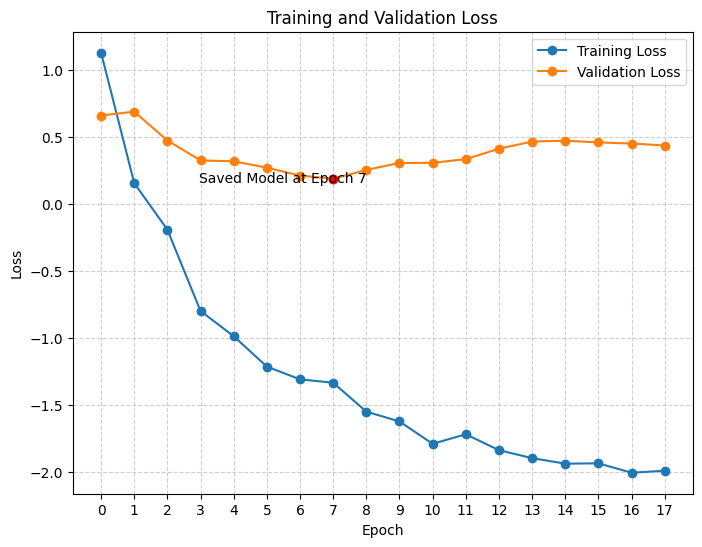

In [17]:
import numpy as np
epochs = np.arange(len(train_loss))
lowest_val_idx = np.argmin(val_loss)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Annotate the lowest validation loss
plt.scatter(lowest_val_idx, val_loss[lowest_val_idx], color='red', zorder=3)
plt.text(lowest_val_idx + 1, val_loss[lowest_val_idx] - 0.05, 
         f'Saved Model at Epoch {lowest_val_idx}', 
         fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(epochs)  # Set x-axis ticks explicitly as factors (0, 1, 2, ...)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:
all_ids = total_data.projid.unique()
all_sequences = utils_BiLSTMasTrue.create_sequences(total_data, all_ids, feature_columns, target_columns)

training_r2, train_loss, val_loss, lr_history = utils_BiLSTMasTrue.train_and_evaluate_model(
    train_data=all_sequences,
    test_data=all_sequences,
    input_dim=len(feature_columns),
    output_dim=len(target_columns),  
    num_epochs=500,
    patience=10,
    lr_scheduler_patience=5,
    lr_factor=0.5,
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    batch_size=hp['batch_size'],
    learning_rate=hp['learning_rate'],
    dropout_rate=hp['dropout_rate'],
    bidirectional=is_bidirectional, # This will be True
    seed=1217,
    model_save_path=str(amyloid_model_save_path)
)

/Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/scripts/S4_Training_ML_Models_and_Predicting_Pathologies_only_for_Livings/S4.1_Retraining_using_all_decedents_samples_for_imputing_pathologies_for_livings/utils_BiLSTMasTrue.py:476: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

In [19]:
training_r2_with_names = dict(zip(target_columns, [round(value, 6) for value in training_r2]))
print(training_r2_with_names)

{'gpath': 0.313897, 'tangles': 0.320305, 'amyloid': 0.408436, 'niareagansc': 0.368897}


# Final model for nia (BiLSTM)

In [20]:
# ==========================================
# NIAREAGANSC Training
# ==========================================
target_name = 'niareagansc'
cfg = MODEL_PARAMS[target_name]
hp = cfg['hyperparameters']

print(f"--- Training {target_name} ---")

# 1. Dynamically select module
current_module, is_bidirectional = get_model_settings(cfg['architecture'])

# 2. Prepare Data
feature_columns = total_data.drop(columns=['projid', 'study', 'fu_year', 'cogdx', 
                                             'amyloid', 'gpath', 'tangles', 'niareagansc']).columns.tolist()
target_columns = cfg['target_columns']

train_ids = total_data.projid.unique()
train_sequences = current_module.create_sequences(total_data, train_ids, feature_columns, target_columns)

test_ids = total_data.projid.unique()
test_sequences = current_module.create_sequences(total_data, test_ids, feature_columns, target_columns)

# 3. Train Model
test_r2, train_loss, val_loss, lr_history = current_module.train_and_evaluate_model(
    train_data=train_sequences,
    test_data=test_sequences,
    input_dim=len(feature_columns),
    output_dim=len(target_columns),  
    num_epochs=500,
    patience=10,
    lr_scheduler_patience=5,
    lr_factor=0.5,
    # --- Load from Config ---
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    batch_size=hp['batch_size'],
    learning_rate=hp['learning_rate'],
    dropout_rate=hp['dropout_rate'],
    bidirectional=is_bidirectional,
    # --------------------
    seed=1217,
    temporary=True
)

--- Training niareagansc ---


/Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/scripts/S4_Training_ML_Models_and_Predicting_Pathologies_only_for_Livings/S4.1_Retraining_using_all_decedents_samples_for_imputing_pathologies_for_livings/utils_BiLSTMasTrue.py:476: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

In [21]:
test_r2_with_names = dict(zip(target_columns, [round(value, 6) for value in test_r2]))
print(test_r2_with_names)

{'gpath': 0.249635, 'tangles': 0.298256, 'amyloid': 0.31951, 'niareagansc': 0.322491}


- Using the best parameter for nia, the LSTM test $R^2$ for tangles is 0.35061
- The elastic-net test $R^2$ for tangles is 0.305

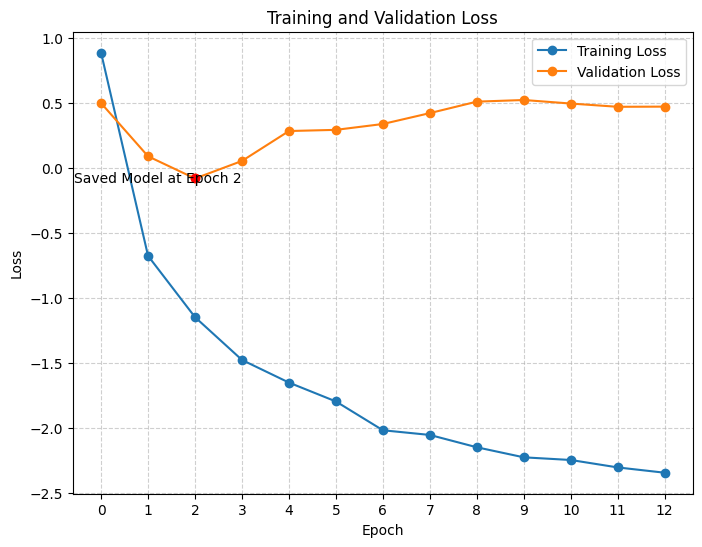

In [22]:
import numpy as np
epochs = np.arange(len(train_loss))
lowest_val_idx = np.argmin(val_loss)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Annotate the lowest validation loss
plt.scatter(lowest_val_idx, val_loss[lowest_val_idx], color='red', zorder=3)
plt.text(lowest_val_idx + 1, val_loss[lowest_val_idx] - 0.05, 
         f'Saved Model at Epoch {lowest_val_idx}', 
         fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(epochs)  # Set x-axis ticks explicitly as factors (0, 1, 2, ...)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Train the selected model on the entire dataset (combining both training and testing data) to predict estimated brain pathologies for subsequent clustering analysis.

In [23]:
all_ids = total_data.projid.unique()
all_sequences = utils_BiLSTMasTrue.create_sequences(total_data, all_ids, feature_columns, target_columns)

training_r2, train_loss, val_loss, lr_history = utils_BiLSTMasTrue.train_and_evaluate_model(
    train_data=all_sequences,
    test_data=all_sequences,
    input_dim=len(feature_columns),
    output_dim=len(target_columns),  
    num_epochs=500,
    patience=10,
    lr_scheduler_patience=5,
    lr_factor=0.5,
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    batch_size=hp['batch_size'],
    learning_rate=hp['learning_rate'],
    dropout_rate=hp['dropout_rate'],
    bidirectional=is_bidirectional,
    # --------------------
    seed=1217,
    model_save_path=str(nia_model_save_path)
)

/Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/scripts/S4_Training_ML_Models_and_Predicting_Pathologies_only_for_Livings/S4.1_Retraining_using_all_decedents_samples_for_imputing_pathologies_for_livings/utils_BiLSTMasTrue.py:476: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

In [24]:
training_r2_with_names = dict(zip(target_columns, [round(value, 6) for value in training_r2]))
print(training_r2_with_names)

{'gpath': 0.249635, 'tangles': 0.298256, 'amyloid': 0.31951, 'niareagansc': 0.322491}


Training $R^2$ looks reasonable.